In [171]:
import numpy as np
import pandas as pd
import sympy
import os
import csv
from random import randint
import matplotlib.pyplot as plt
from statistics import mean

In [172]:
class HashSearchExternal():

    def __init__(self, path_to_array_file=None, path_to_index_file=None, path_to_folder_of_index_file=None, block_size=5):
        """
        self.path_to_array_file - Путь к файлу с ключами для хэша
        self.path_to_index_file - Путь к индексному файлу
        self.path_to_folder_of_index_file - Папка где хранятся файлы с ключами для каждого адреса
        self.hash_len - Длинна хэша и кол-во файлов для адресов хэша
        self.block_size - Размер блоков для информации
        self.count_of_iterations_to_solve_collision - Кол-во итераций для эксперемента
        self.success_of_finding_number - Успех в проведении эксперемента
        """

        self.path_to_array_file = path_to_array_file
        self.path_to_index_file = path_to_index_file
        self.path_to_folder_of_index_file = path_to_folder_of_index_file
        self.hash_len = None
        self.block_size = block_size
        self.count_of_iterations_to_solve_collision = 0
        self.success_of_finding_number = False
        pass

    def create_hash(self, path_to_array_file, path_to_index_file, path_to_folder_of_index_file, prefeared_len=3, block_size=5):
        """
        Эта функция позволяет создать хэш, который будет распределён в фалах в блочной структуре
        path_to_array_file - Путь к файлу с ключами для хэша
        path_to_index_file - Путь к индексному файлу
        path_to_folder_of_index_file - Папка где хранятся файлы с ключами для каждого адреса
        prefeared_len - Кол-во адресов в хэше
        block_size - Размер блоков для файлов с ключами
        """
        # Передаём начальную информацию в класс
        self.__init__(path_to_array_file, path_to_index_file, path_to_folder_of_index_file)
        # Далее если требуется, то создаём папку для адресов хэша
        check_file = os.path.exists(path_to_folder_of_index_file)
        if (check_file == False):
            os.mkdir(path_to_folder_of_index_file)
        # Далее задаём кол-во адресов в хэше
        if (prefeared_len > 0):
            self.hash_len = prefeared_len
            self.__create_index_file(prefeared_len)
        else:
            self.hash_len = 3
            self.__create_index_file(3)
        # Далее задаём размер блоков
        if (block_size > 0):
            self.block_size = block_size
        else:
            self.block_size = 5
        # Избавляемся од дублирующихся ключей
        self.__destroy_duplicate_numbers()
        # Вносим информацию в файлых для адресов хэша
        self.__set_information_in_hash_files()

        pass

    def create_hash_from_file(self):
        """
        Эта функция позволяет нагладно расписать хэш, собрав его из адресных файлов
        """
        # Получаем файлы для адресов хэша
        paths_of_index_file = np.loadtxt(self.path_to_index_file, dtype="str")
        # Счётчик будет показывать какой адрес хэша у нас распечатан
        counter = 0
        # Для каждого файла выводим информацию о нём
        for i in paths_of_index_file:
            # Читаем информацию из адресного файла
            with open(i, 'r') as f:
                information = list(csv.reader(f, delimiter=","))
            # Меняем все переменные из str в int
            information = [[int(j) for j in i] for i in information]
            # Избавляемся от инкриптера (показывает кол-во свободных ячеек в блоке)
            information = [i[1:] for i in information]

            print(f"Адрес: {counter} имеет Ключи: {information}")
            counter += 1

        pass

    def experement_in_hash(self, number_to_find):
        """
        Эта функция позволяет провести эксперемент с хэщем.
        Суть эксперемента - записать число в хэш. Если это число уже есть в хэше,
        То останавливаемся и получаем неудачу эксперемента.
        В хлде эксперемента просчитывается кол-во операций обращений к блокам из файла адреса
        number_to_find - цифра которую требуется записать в хэш
        """
        # Из индексного файла получаем пути к файлам адреса хэша
        paths_of_index_file = np.loadtxt(self.path_to_index_file, dtype="str")
        # Высчитываем хэш функцию для нашего номера
        index_for_number = abs(number_to_find) % self.hash_len

        # Поблочно считываем информацию из адресного файла
        with open(paths_of_index_file[index_for_number], 'r') as f:
            information = list(csv.reader(f, delimiter=","))

        information = [[int(j) for j in i] for i in information]
        keys = [j[1:] for j in information]

        # Проходясь по блокам ищем повторения числа и свободное место для числа
        for i in range(len(information)):
            self.count_of_iterations_to_solve_collision += 1
            # Если номер повторяет, то возвращяем неудачу
            if (number_to_find in keys[i]):
                self.success_of_finding_number = False
                break
            # Если мы нашли свободное место, то влзвращаем успех
            if (information[i][0] > 0):
                self.success_of_finding_number = True
                break

        pass

    def __destroy_duplicate_numbers(self):
        """
        Эта функция позволяет избавится от дублирующихся ключей
        """
        # Получаем ключи из файла с ними
        numbers_from_file = np.loadtxt(self.path_to_array_file, dtype="int", delimiter=',')
        # Выполняем функцию по избавлению от повторяющихся элементов
        arr = np.unique(numbers_from_file)
        # Перезаписываем новую последовательность ключей в файл
        with open(self.path_to_array_file, "w+") as file:
            file.write(",".join(list(map(str, arr))))

        pass

    def __set_information_in_hash_files(self):
        """
        Эта функция позволяет создать хэш
        А именно записать информацию в адресные файлы, сохраняя блочную структуру
        """
        # Из индексного файла получаем пути к файлам адреса хэша
        paths_of_index_file = np.loadtxt(self.path_to_index_file, dtype="str")
        # Получаем массив ключей для хэша из файла
        with open(self.path_to_array_file, 'r') as f:
            numbers_from_file = list(csv.reader(f, delimiter=","))
        numbers_from_file = [int(i) for i in numbers_from_file[0]]

        # Ищем для каждого люча пустое место в адресном файле
        for i in range(len(numbers_from_file)):
            # Расчитываем хэш функцию для ключа
            index_for_number = abs(numbers_from_file[i]) % self.hash_len

            # Открываем файл
            with open(paths_of_index_file[index_for_number], 'r') as f:
                information = list(csv.reader(f, delimiter=","))

            information = [[int(j) for j in i] for i in information]
            # Проверяем на то есть ли в этом файле блок
            if (information == []):
                # Если нет, то создаём блок
                information = [[self.block_size]]
            # Проверяем все ли блоки заполнены
            elif (information[-1][0] == 0):
                # Если да, то создаём новый блок
                information.append([self.block_size])

            # Записываем информацию в блок
            information[-1].append(numbers_from_file[i])
            information[-1][0] -= 1

            with open(paths_of_index_file[index_for_number], 'w', newline='\n') as file:
                for row_of_information in information:
                    w = csv.writer(file)
                    w.writerow(row_of_information)

        pass


    def __create_index_file(self, hash_len):
        """
        Эта функция позволяет пересоздать файлы для адресов хэша
        hash_len - размер хэша (кол-во файлов которые будут пересозданы)
        """
        # Пересоздаём индексный файл
        open(self.path_to_index_file, "w+")
        for i in range(hash_len):
            # Записываем путь к файлу адреса хэша
            index_file = open(self.path_to_index_file, "a+")
            index_file.write(f"{self.path_to_folder_of_index_file}/hash_index{i}.csv\n")
            # Пересоздаём файлу адреса хэша
            open(f"{self.path_to_folder_of_index_file}/hash_index{i}.csv", "w+")
        pass


HSE = HashSearchExternal()

In [173]:
def create_visualisation_of_experement(HSE, hash_len, sd=4,
                                       path_to_array_file=None,
                                       path_to_index_file=None,
                                       path_to_folder_of_index_file=None,
                                       prefeared_len=3,
                                       block_size=5):
    """
    Эта функция позволяет провести множество эксперементов по добвлению числа в хэш
    HSE - класс хэш функции метода деления
    hash_len - для скольких чисел будет проводится эксперемент
    sd - стандартное отклонение
    path_to_array_file - Путь к файлу с ключами для хэша
    path_to_index_file - Путь к индексному файлу
    path_to_folder_of_index_file - Папка где хранятся файлы с ключами для каждого адреса
    prefeared_len - кол-во файлов для адресов хэша
    block_size - размер блока для адресных файлов
    """
   # Объявляем массивы для кол-ва итераций и успешности нашего хэщ-поиска
    array_of_iterations = list()
    array_of_successes = list()
    # Далее проходимся по массиву длин нашего хэша
    for i in hash_len:
        # Создаём случайные ключи и записываем их в файл
        a = list(np.random.normal(0, sd, size=i).astype(int))
        with open(path_to_array_file, "w+") as file:
            file.write(",".join(list(map(str, a))))
        
        # После чего создаём хэш и проводи эксперемент
        HSE.create_hash(path_to_array_file, path_to_index_file, path_to_folder_of_index_file,
                        prefeared_len=prefeared_len, block_size=block_size)
        HSE.experement_in_hash(int(np.random.normal(0, sd)))

        # После чего записываем результаты в массивы
        array_of_iterations.extend([HSE.count_of_iterations_to_solve_collision])
        array_of_successes.extend([HSE.success_of_finding_number])

    # По уже созданным массивам создаём таблицу с результатми наших вычислений
    # Таблица будет состоять из столбцов кол-ва итераций и их успешности
    sr_for_iterations = pd.Series(data=array_of_iterations, index=hash_len)
    sr_for_successes = pd.Series(data=array_of_successes, index=hash_len)
    df_result = pd.DataFrame({"Кол-во итераций": sr_for_iterations, "Успех операции": sr_for_successes})

    # Производим вывод кол-ва неудачных поисков
    print(
        f"Кол-во неудач поиска значения значений в хэш: {df_result.loc[df_result['Успех операции'] == False].count()[0]}")
    # Распечатываем участи таблицы, где у нас произошёл успешный поиск и кол-во затраченных итераций > 0
    print(df_result.loc[df_result['Успех операции'] == True].loc[df_result['Кол-во итераций'] > 0])
    
    # Визуализируем информацию
    with plt.style.context('seaborn'):
            fig = plt.figure(figsize=(22,13))
            ax = fig.add_subplot()
            
            ax.plot(df_result["Кол-во итераций"], marker="H", markersize=4,
                    label="Кол-во итераций для поиска места для числа")
            ax.plot(np.arange(0, max(hash_len)), np.arange(0, max(hash_len)), label=r'$f(x) = O(n)$')
            ax.scatter(x=df_result.loc[df_result["Успех операции"] == False].index.values, 
                       y=df_result["Кол-во итераций"].loc[df_result["Успех операции"] == False],
                       color="r", label="Неуспех поиска места для числа")
            
            ax.tick_params(axis='both', labelsize=12)
            plt.legend(fontsize=24)
            plt.show()

In [174]:
def create_visualisation_of_experement_multiple(HSE, hash_len, amount_of_repeats=3, sd=4, 
                                                path_to_array_file=None, 
                                                path_to_index_file=None, 
                                                path_to_folder_of_index_file=None, 
                                                prefeared_len=3, 
                                                block_size=5):
    """
    Эта функция позволяет провести множество эксперементов по добвлению числа в хэш повторением эксперемнта нексколько раз
    HSE - класс хэш функции метода деления
    hash_len - для скольких чисел будет проводится эксперемент
    sd - стандартное отклонение
    path_to_array_file - Путь к файлу с ключами для хэша
    path_to_index_file - Путь к индексному файлу
    path_to_folder_of_index_file - Папка где хранятся файлы с ключами для каждого адреса
    prefeared_len - кол-во файлов для адресов хэша
    block_size - размер блока для адресных файлов
    """
    # Объявляем массивы для кол-ва итераций и успешности нашего хэщ-поиска
    array_of_iterations = [[] for _ in hash_len]

    index = 0
    # Далее проходимся по массиву длин нашего хэша
    for i in hash_len:
        for j in range(amount_of_repeats):
            # Создаём случайные ключи и записываем их в файл
            a = list(np.random.normal(0, sd, size=i).astype(int))
            with open(path_to_array_file, "w+") as file:
                file.write(",".join(list(map(str, a))))
            
            # После чего создаём хэш и проводи эксперемент
            HSE.create_hash(path_to_array_file, path_to_index_file, path_to_folder_of_index_file, 
                            prefeared_len=prefeared_len, block_size=block_size)
            HSE.experement_in_hash(int(np.random.normal(0, sd)))


            # После чего записываем результаты в массивы
            array_of_iterations[index].extend([HSE.count_of_iterations_to_solve_collision])

        index += 1
    
    # Результат вычислений, а точнее их среднее
    result_array = [mean(i) for i in array_of_iterations]
    sr_for_iterations = pd.Series(data=result_array, index=hash_len)
    
    # Визуализируем информацию
    with plt.style.context('seaborn'):
            fig = plt.figure(figsize=(22,13))
            ax = fig.add_subplot()
            
            ax.plot(sr_for_iterations, marker="H", markersize=4,
                    label="Кол-во итераций для поиска места для числа")
            ax.plot(np.arange(0, max(hash_len)), np.arange(0, max(hash_len)), label=r'$f(x) = O(n)$')

            ax.tick_params(axis='both', labelsize=12)
            plt.legend(fontsize=24)
            plt.show()
    
    pass

In [175]:
path_to_array_file = "Array.txt"
path_to_index_file = "Index.txt"
path_to_folder_of_index_file = "Files_of_hash_indexes"

In [176]:
a = [1, 2, 3, 4, 5, 6]
with open(path_to_array_file, "w+") as file:
    file.write(",".join(list(map(str, a))))
    
HSE.create_hash(path_to_array_file, path_to_index_file, path_to_folder_of_index_file)
HSE.create_hash_from_file()

Адрес: 0 имеет Ключи: [[3, 6]]
Адрес: 1 имеет Ключи: [[1, 4]]
Адрес: 2 имеет Ключи: [[2, 5]]


In [177]:
a = [3, 3, 3, 3, 9, 9, 9]
with open(path_to_array_file, "w+") as file:
    file.write(",".join(list(map(str, a))))
    
HSE.create_hash(path_to_array_file, path_to_index_file, path_to_folder_of_index_file)
HSE.create_hash_from_file()

Адрес: 0 имеет Ключи: [[3, 9]]
Адрес: 1 имеет Ключи: []
Адрес: 2 имеет Ключи: []


In [178]:
a = list(range(0, 16))
with open(path_to_array_file, "w+") as file:
    file.write(",".join(list(map(str, a))))
    
HSE.create_hash(path_to_array_file, path_to_index_file, path_to_folder_of_index_file)
HSE.create_hash_from_file()

Адрес: 0 имеет Ключи: [[0, 3, 6, 9, 12], [15]]
Адрес: 1 имеет Ключи: [[1, 4, 7, 10, 13]]
Адрес: 2 имеет Ключи: [[2, 5, 8, 11, 14]]


In [180]:
a = np.random.randint(200, size=200)
with open(path_to_array_file, "w+") as file:
    file.write(",".join(list(map(str, a))))
    
HSE.create_hash(path_to_array_file, path_to_index_file, path_to_folder_of_index_file, prefeared_len=6, block_size=4)
HSE.create_hash_from_file()

Адрес: 0 имеет Ключи: [[0, 6, 12, 24], [30, 36, 54, 60], [66, 72, 78, 84], [90, 96, 102, 108], [144, 150, 156, 174], [180, 186, 192, 198]]
Адрес: 1 имеет Ключи: [[1, 7, 13, 19], [37, 49, 55, 67], [73, 79, 103, 115], [121, 127, 133, 151], [157, 163, 187, 199]]
Адрес: 2 имеет Ключи: [[2, 8, 20, 26], [44, 50, 56, 62], [74, 80, 86, 92], [104, 116, 134, 140], [146, 164, 170, 188], [194]]
Адрес: 3 имеет Ключи: [[15, 27, 33, 51], [69, 87, 93, 105], [123, 129, 147, 153], [159, 165, 171, 177], [183, 189]]
Адрес: 4 имеет Ключи: [[4, 22, 34, 46], [58, 82, 88, 100], [112, 124, 142, 148], [154, 160, 166, 184], [190]]
Адрес: 5 имеет Ключи: [[11, 23, 41, 47], [53, 59, 65, 77], [83, 89, 95, 101], [107, 113, 119, 125], [131, 137, 143, 155], [167, 173, 179, 185], [191, 197]]


Кол-во неудач поиска значения значений в хэш: 11
    Кол-во итераций  Успех операции
2                 1            True
3                 1            True
5                 2            True
7                 2            True
11                2            True
19                3            True
29                4            True
31                5            True
37                6            True
41                7            True
43                4            True
53                5            True
71                7            True
89               12            True


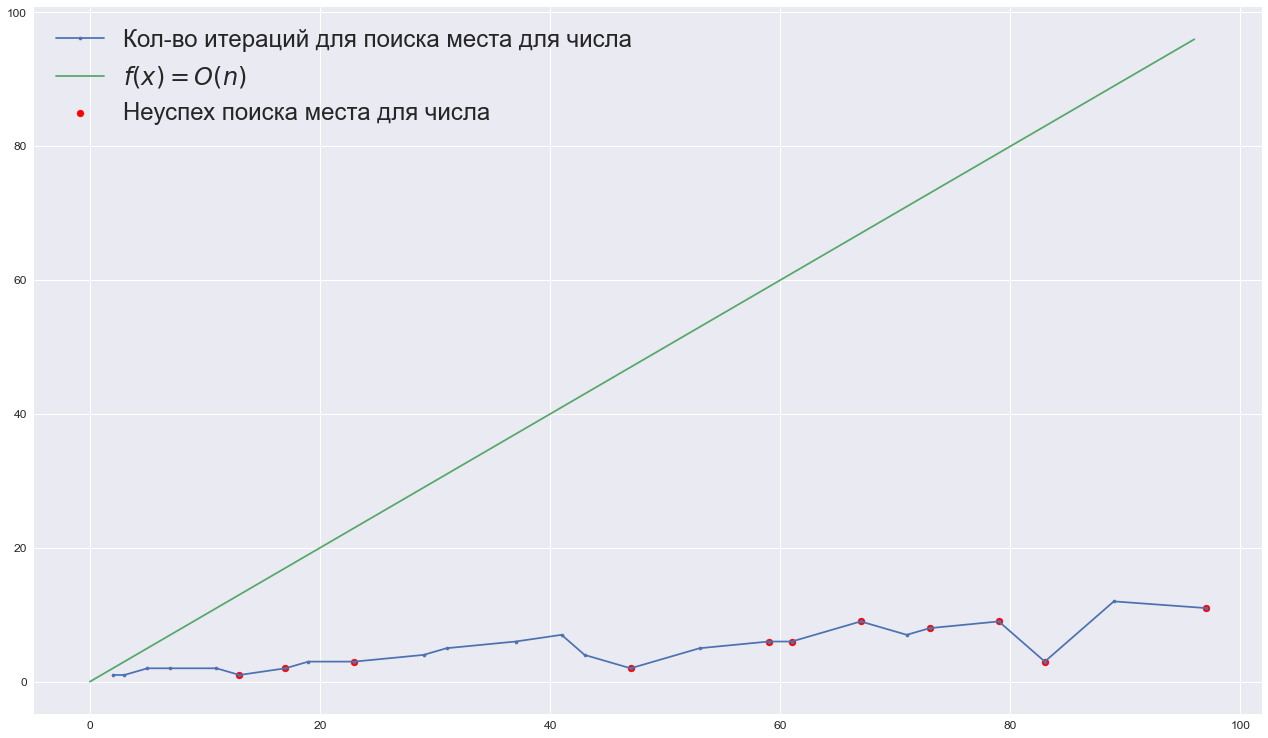

In [143]:
create_visualisation_of_experement(HSE, list(sympy.primerange(0, 100)), sd=100, 
                                   path_to_array_file=path_to_array_file, 
                                   path_to_index_file=path_to_index_file, 
                                   path_to_folder_of_index_file=path_to_folder_of_index_file,
                                   prefeared_len=4,
                                   block_size=2)

Кол-во неудач поиска значения значений в хэш: 16
    Кол-во итераций  Успех операции
5                 2            True
17                2            True
19                2            True
29                4            True
37                5            True
43                7            True
47                5            True
53                5            True
73                6            True


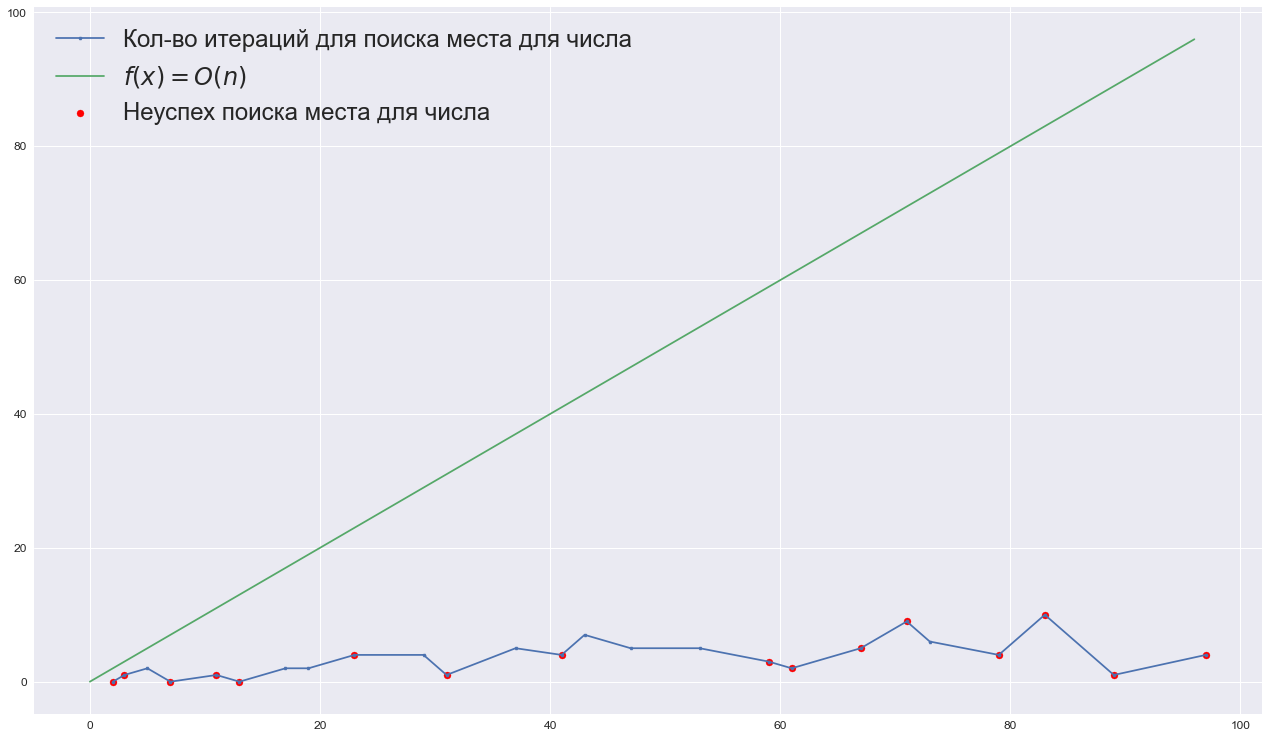

In [144]:
create_visualisation_of_experement(HSE, list(sympy.primerange(0, 100)), sd=50, 
                                   path_to_array_file=path_to_array_file, 
                                   path_to_index_file=path_to_index_file, 
                                   path_to_folder_of_index_file=path_to_folder_of_index_file,
                                   prefeared_len=4,
                                   block_size=2)

Кол-во неудач поиска значения значений в хэш: 21
    Кол-во итераций  Успех операции
3                 1            True
11                2            True
17                1            True
79                4            True


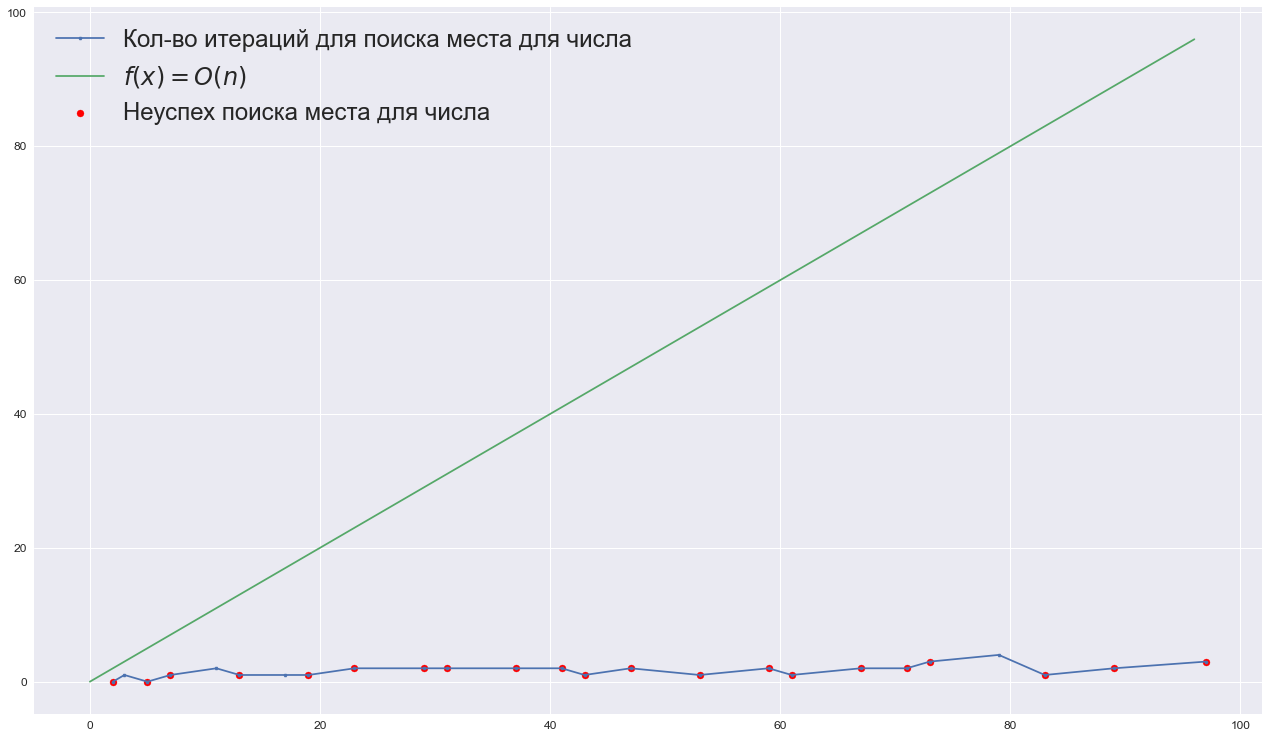

In [145]:
create_visualisation_of_experement(HSE, list(sympy.primerange(0, 100)), sd=5, 
                                   path_to_array_file=path_to_array_file, 
                                   path_to_index_file=path_to_index_file, 
                                   path_to_folder_of_index_file=path_to_folder_of_index_file,
                                   prefeared_len=4,
                                   block_size=2)

Кол-во неудач поиска значения значений в хэш: 25
Empty DataFrame
Columns: [Кол-во итераций, Успех операции]
Index: []


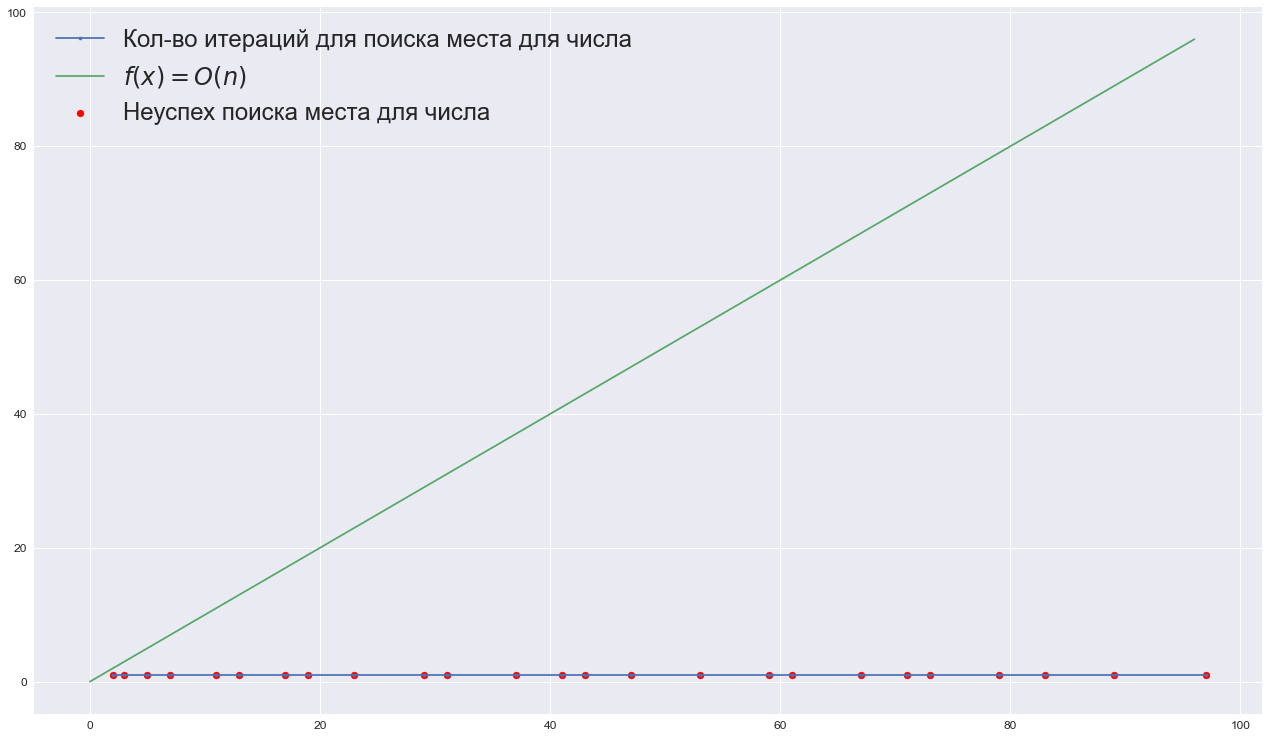

In [153]:
create_visualisation_of_experement(HSE, list(sympy.primerange(0, 100)), sd=0.5, 
                                   path_to_array_file=path_to_array_file, 
                                   path_to_index_file=path_to_index_file, 
                                   path_to_folder_of_index_file=path_to_folder_of_index_file,
                                   prefeared_len=4,
                                   block_size=2)

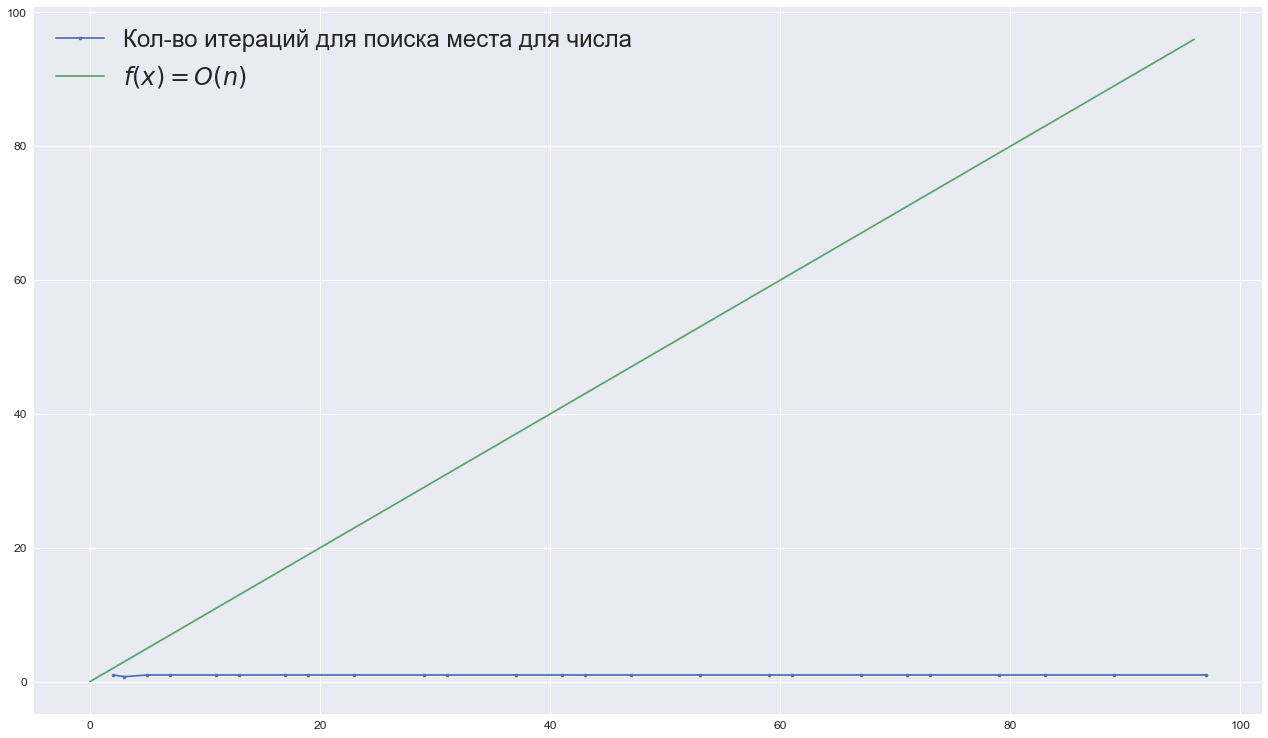

In [154]:
create_visualisation_of_experement_multiple(HSE, list(sympy.primerange(0, 100)), amount_of_repeats=4, sd=0.5, 
                                   path_to_array_file=path_to_array_file, 
                                   path_to_index_file=path_to_index_file, 
                                   path_to_folder_of_index_file=path_to_folder_of_index_file,
                                   prefeared_len=4,
                                   block_size=2)

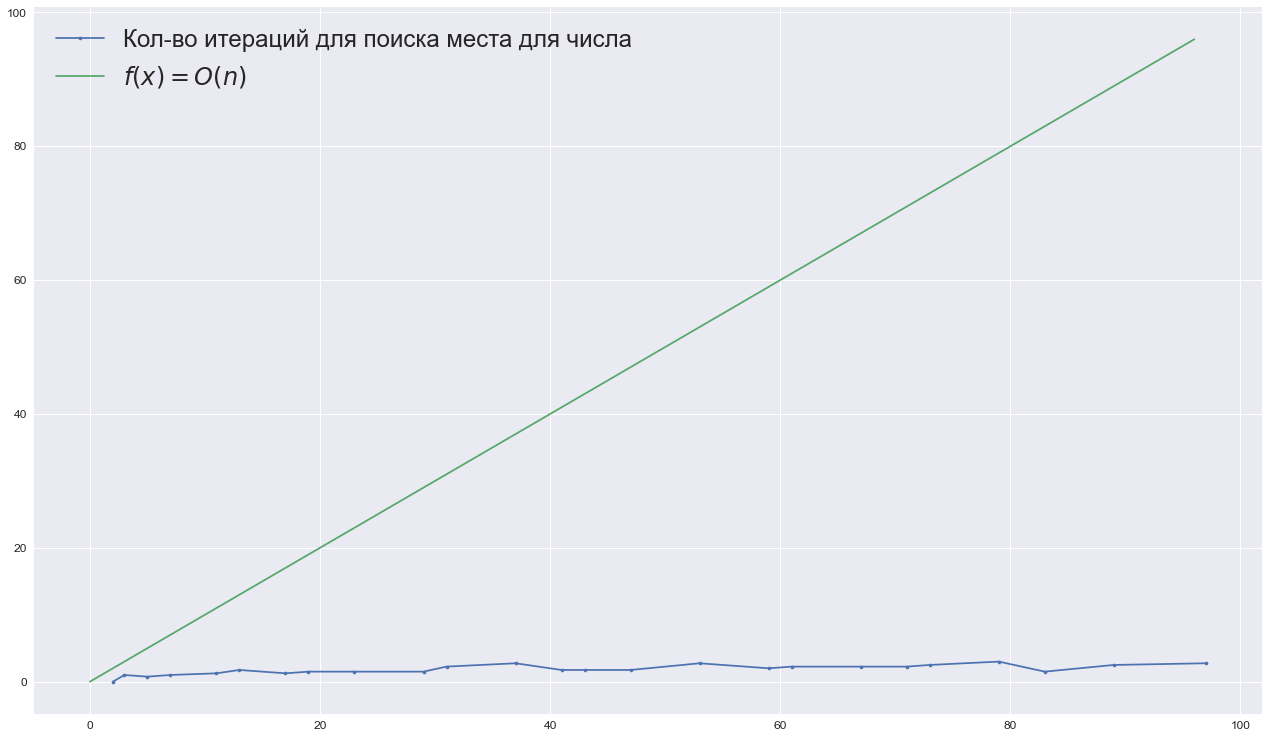

In [155]:
create_visualisation_of_experement_multiple(HSE, list(sympy.primerange(0, 100)), amount_of_repeats=4, sd=7, 
                                   path_to_array_file=path_to_array_file, 
                                   path_to_index_file=path_to_index_file, 
                                   path_to_folder_of_index_file=path_to_folder_of_index_file,
                                   prefeared_len=4,
                                   block_size=2)

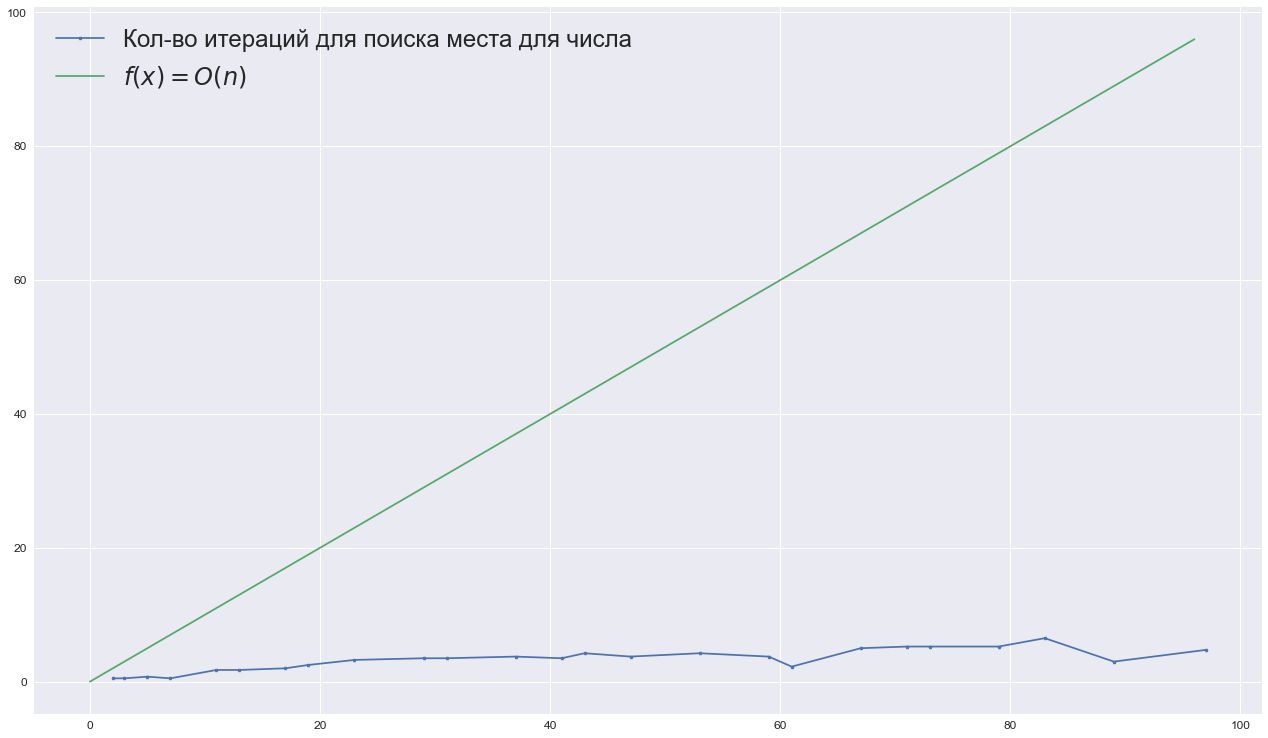

In [156]:
create_visualisation_of_experement_multiple(HSE, list(sympy.primerange(0, 100)), amount_of_repeats=4, sd=25, 
                                   path_to_array_file=path_to_array_file, 
                                   path_to_index_file=path_to_index_file, 
                                   path_to_folder_of_index_file=path_to_folder_of_index_file,
                                   prefeared_len=4,
                                   block_size=2)

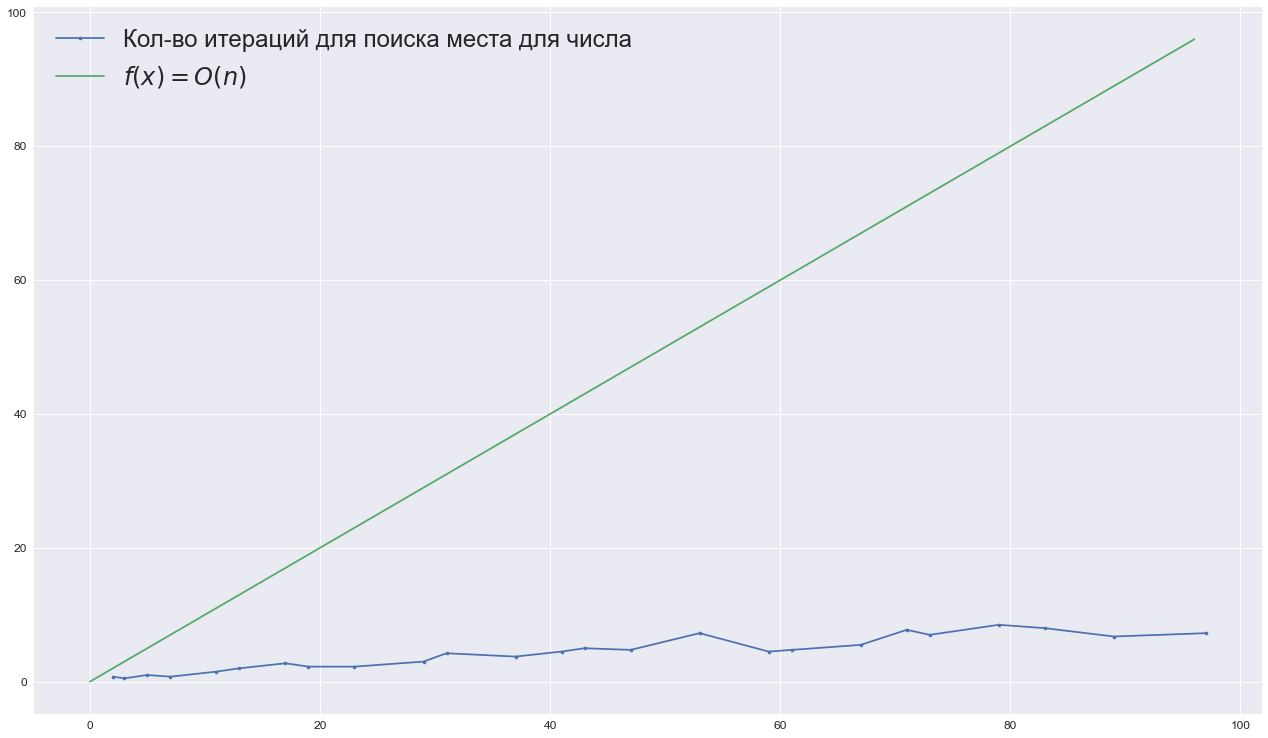

In [157]:
create_visualisation_of_experement_multiple(HSE, list(sympy.primerange(0, 100)), amount_of_repeats=4, sd=50, 
                                   path_to_array_file=path_to_array_file, 
                                   path_to_index_file=path_to_index_file, 
                                   path_to_folder_of_index_file=path_to_folder_of_index_file,
                                   prefeared_len=4,
                                   block_size=2)

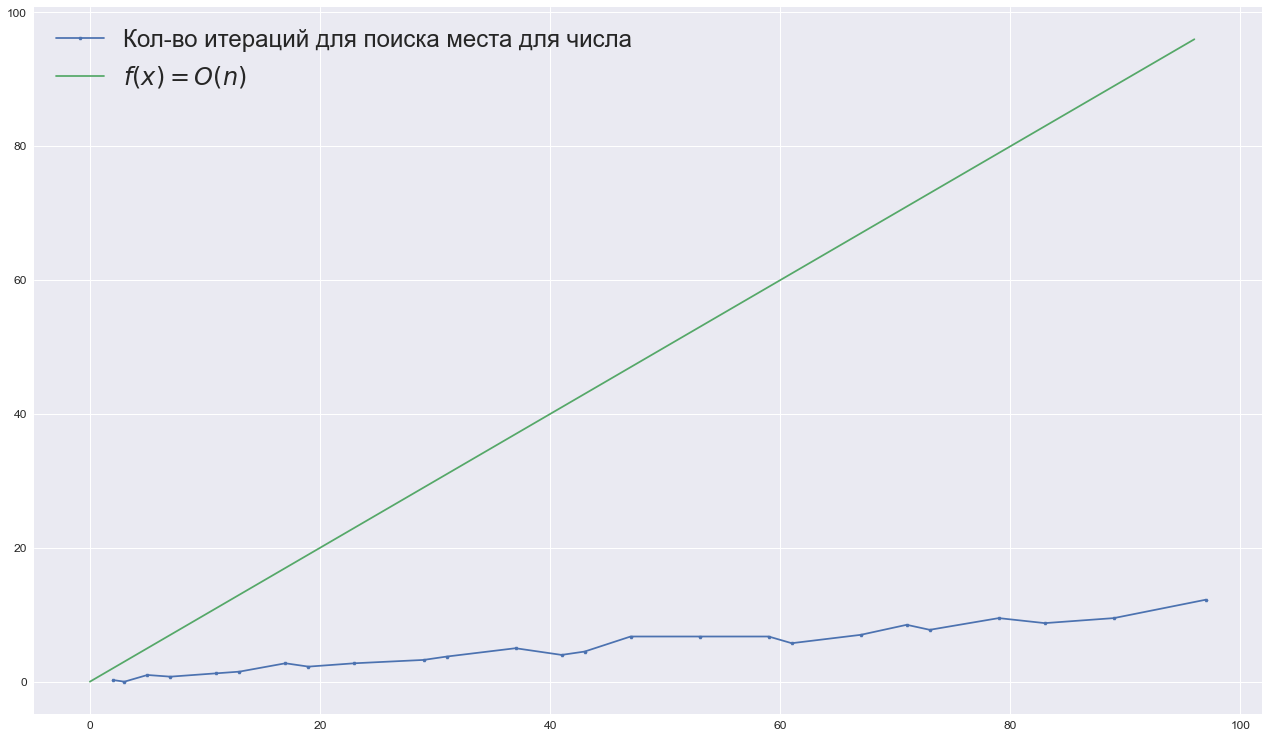

In [158]:
create_visualisation_of_experement_multiple(HSE, list(sympy.primerange(0, 100)), amount_of_repeats=4, sd=100, 
                                   path_to_array_file=path_to_array_file, 
                                   path_to_index_file=path_to_index_file, 
                                   path_to_folder_of_index_file=path_to_folder_of_index_file,
                                   prefeared_len=4,
                                   block_size=2)

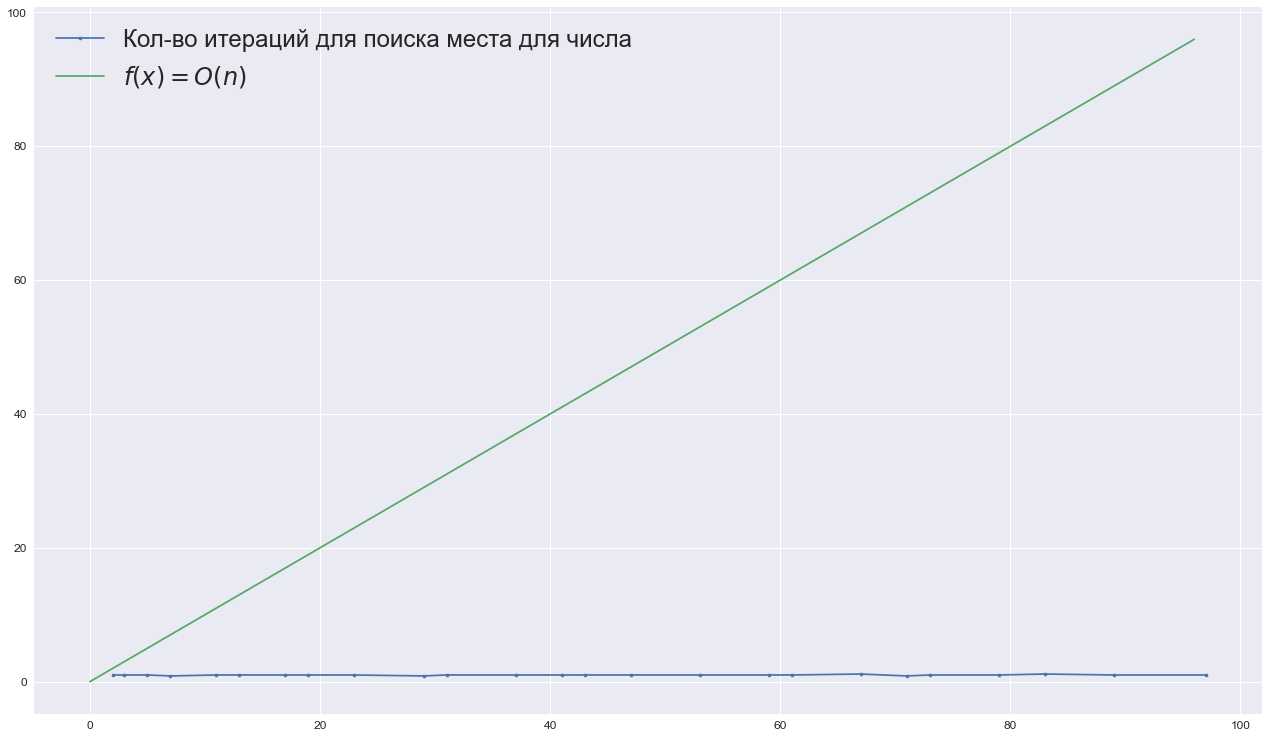

In [159]:
create_visualisation_of_experement_multiple(HSE, list(sympy.primerange(0, 100)), amount_of_repeats=7, sd=0.5, 
                                   path_to_array_file=path_to_array_file, 
                                   path_to_index_file=path_to_index_file, 
                                   path_to_folder_of_index_file=path_to_folder_of_index_file,
                                   prefeared_len=2,
                                   block_size=1)

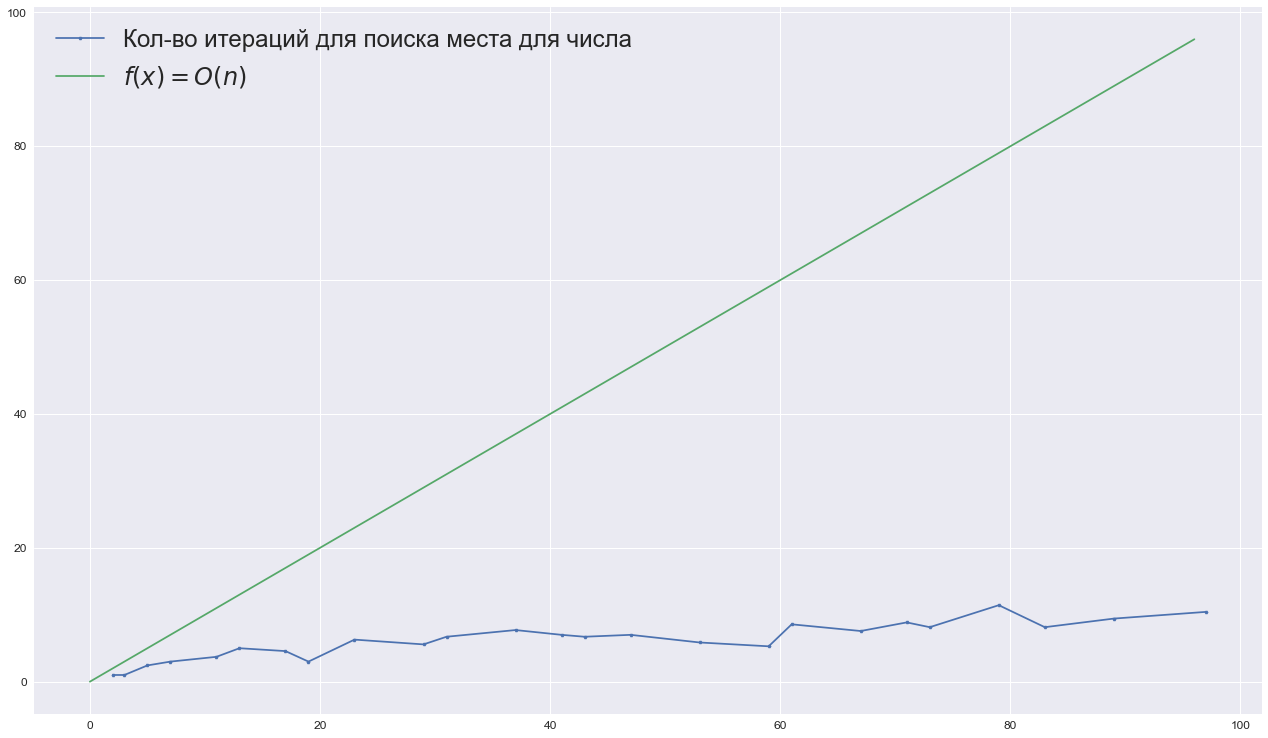

In [160]:
create_visualisation_of_experement_multiple(HSE, list(sympy.primerange(0, 100)), amount_of_repeats=7, sd=7, 
                                   path_to_array_file=path_to_array_file, 
                                   path_to_index_file=path_to_index_file, 
                                   path_to_folder_of_index_file=path_to_folder_of_index_file,
                                   prefeared_len=2,
                                   block_size=1)

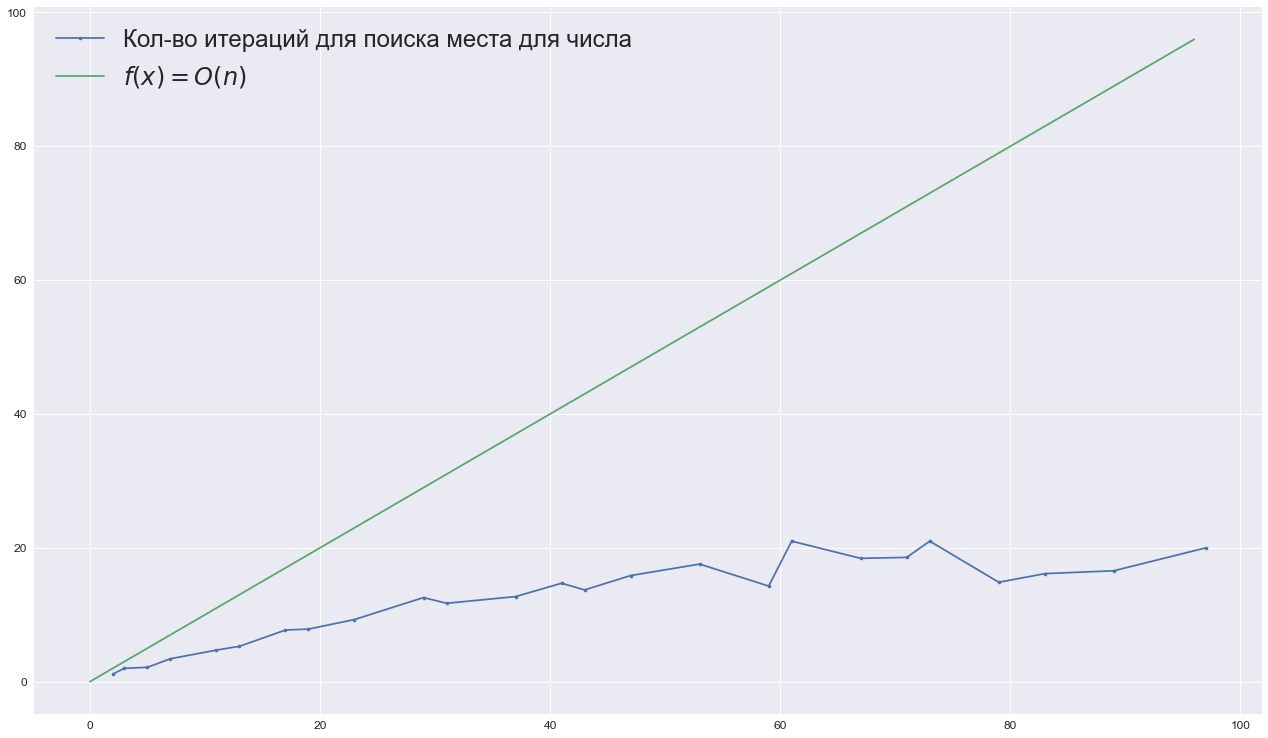

In [161]:
create_visualisation_of_experement_multiple(HSE, list(sympy.primerange(0, 100)), amount_of_repeats=7, sd=25, 
                                   path_to_array_file=path_to_array_file, 
                                   path_to_index_file=path_to_index_file, 
                                   path_to_folder_of_index_file=path_to_folder_of_index_file,
                                   prefeared_len=2,
                                   block_size=1)

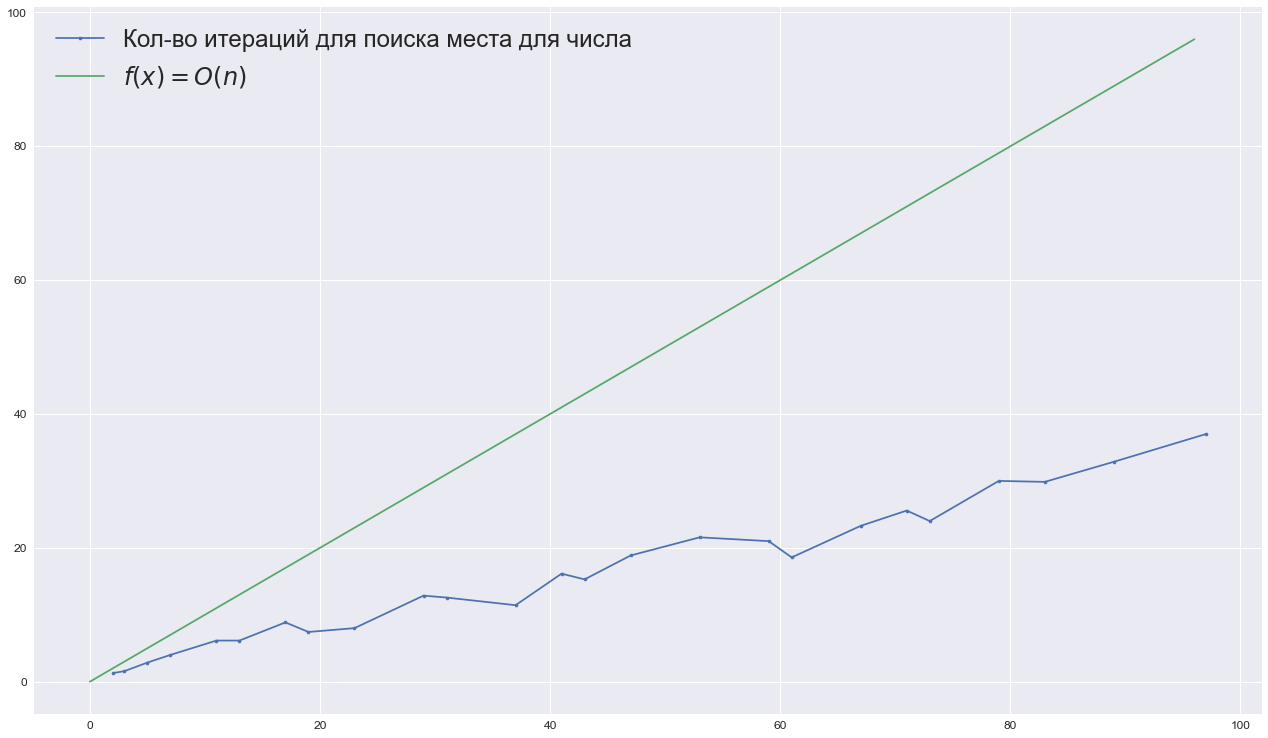

In [162]:
create_visualisation_of_experement_multiple(HSE, list(sympy.primerange(0, 100)), amount_of_repeats=7, sd=50, 
                                   path_to_array_file=path_to_array_file, 
                                   path_to_index_file=path_to_index_file, 
                                   path_to_folder_of_index_file=path_to_folder_of_index_file,
                                   prefeared_len=2,
                                   block_size=1)

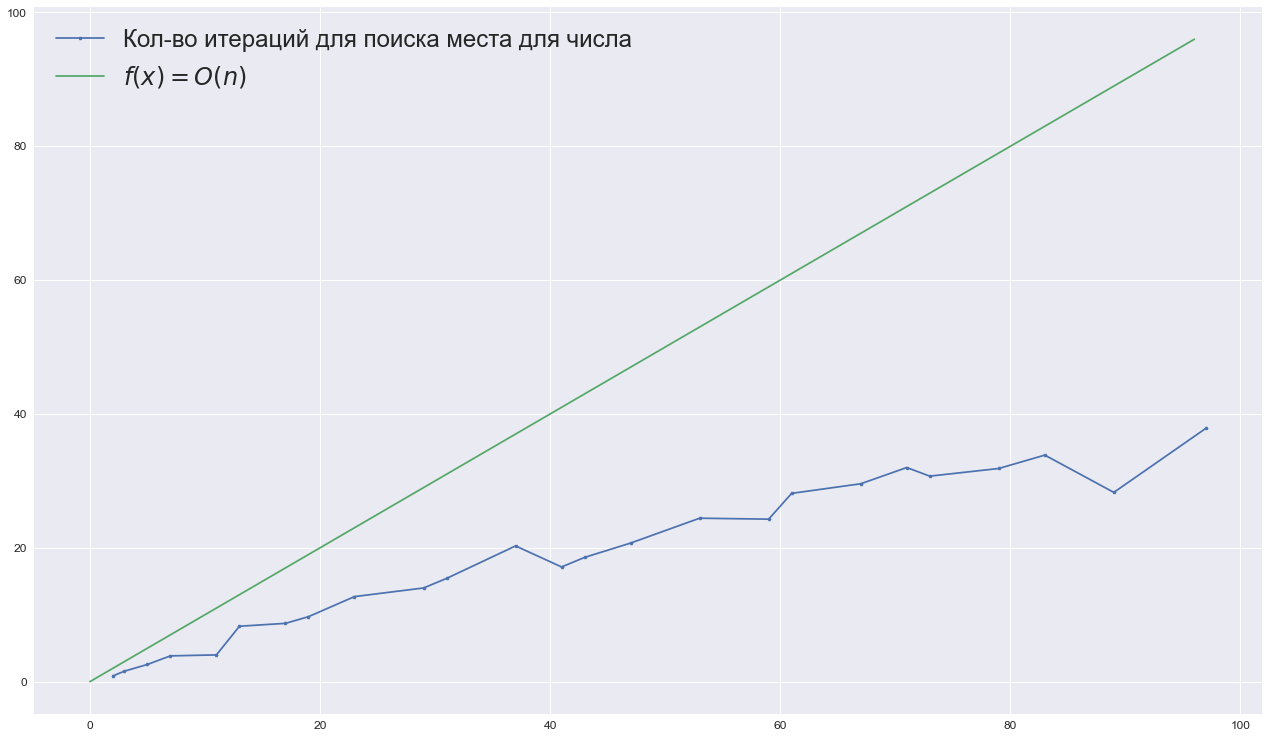

In [163]:
create_visualisation_of_experement_multiple(HSE, list(sympy.primerange(0, 100)), amount_of_repeats=7, sd=100, 
                                   path_to_array_file=path_to_array_file, 
                                   path_to_index_file=path_to_index_file, 
                                   path_to_folder_of_index_file=path_to_folder_of_index_file,
                                   prefeared_len=2,
                                   block_size=1)

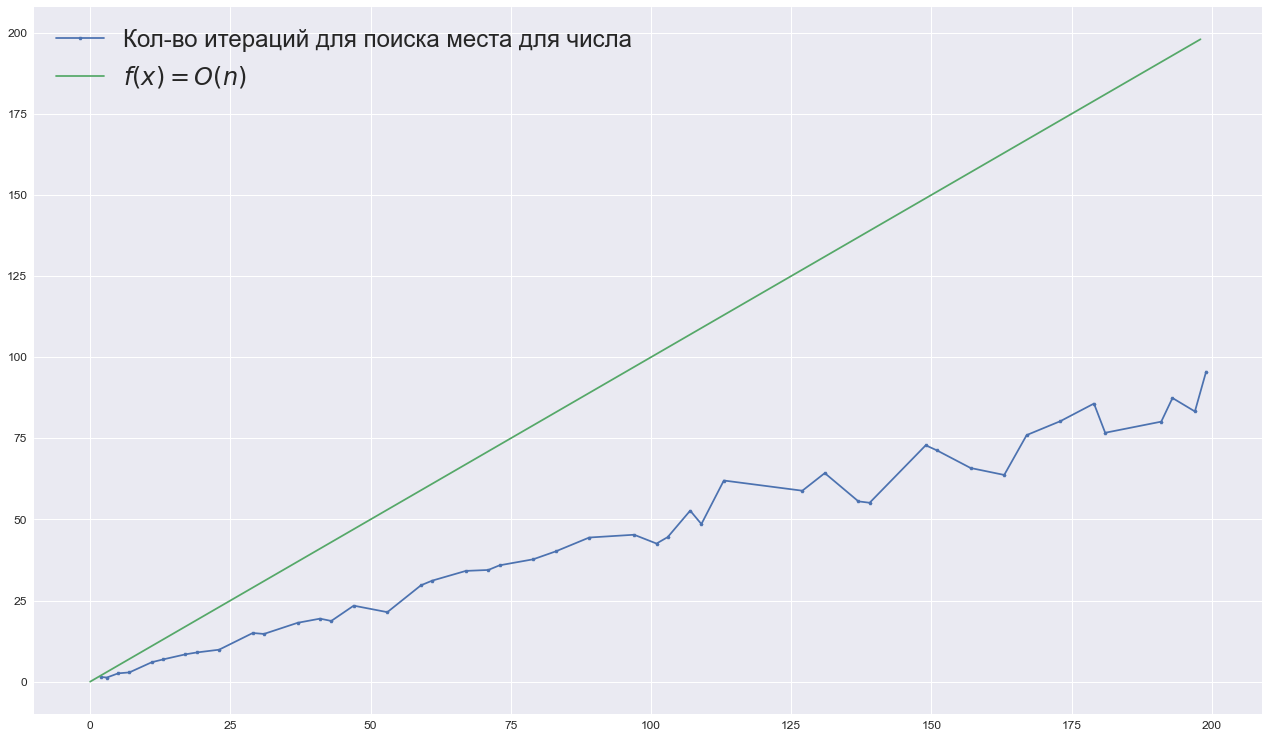

In [164]:
create_visualisation_of_experement_multiple(HSE, list(sympy.primerange(0, 200)), amount_of_repeats=7, sd=500, 
                                   path_to_array_file=path_to_array_file, 
                                   path_to_index_file=path_to_index_file, 
                                   path_to_folder_of_index_file=path_to_folder_of_index_file,
                                   prefeared_len=2,
                                   block_size=1)